#**Dataset Link:**

https://drive.google.com/drive/folders/1NHikQIu29Ht2HpYeMzoV0Dfwrl__yM01?usp=sharing 

# Imports

In [1]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax,LSTM,GRU
from tensorflow.keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers


%matplotlib inline

#Matplotlib setup
plt.rcParams["figure.figsize"] = (3,1)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

# Reading the Input Data

In [2]:
path = '/content/drive/MyDrive/Dataset/mitbih_database/mitbih_database/' 
#input path
window_size = 180
maximum_counting = 10000

classes = ['N', 'S', 'V', 'F', 'Q']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

##Reading files

In [3]:
# Readint input files
filenames = next(os.walk(path))[2]

# Splitting the csv files and annotation files
records = list()
annotations = list()
filenames.sort()

##Seperating files and annotations

In [ ]:
# grouping csv and annotation files
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

# Data Denoising

In [ ]:
def denoise(data): 
    w = pywt.Wavelet('sym4') #syn4 - 4 max level decomposition
    maxlev = pywt.dwt_max_level(len(data), w.dec_len) #max useful decomposition
    threshold = 0.04 # filtering threshold

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev) #adding coefficients
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4') #waverec
    
    return datarec

#Reading R positions and Arrhythmia class

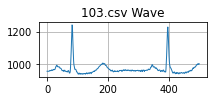

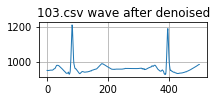

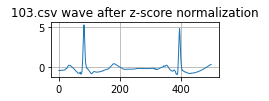

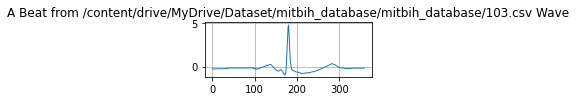

(100012, 360) (100012,)


In [ ]:
# for each records
for r in range(0,len(records)):
    signals = []
    

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read ECG data from .csv
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
  #example plot of a sample 103.csv
    if r is 1:
        # Plot each patient's signal
        plt.title("103.csv Wave")
        plt.plot(signals[0:500])
        #plt.grid(False)
        plt.show()
        
    signals = denoise(signals) #denoising the signal
    # plotting after denoising
    if r is 1:
        plt.title("103.csv wave after denoised")
        plt.plot(signals[0:500])
        plt.show()
        
    signals = stats.zscore(signals) #performing Z score normalisation
    # Plot an example to the signals
    if r is 1:
        plt.title( " 103.csv wave after z-score normalization ")
        plt.plot(signals[0:500])
        plt.show()
    
    # Reading the R peaks and the annotation classes for each sample
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): 
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) 
            pos = int(next(splitted))
            arrhythmia_type = next(splitted) # arrhythmia clas
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)

                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]  #R peaks  
                     
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[3] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

print(np.shape(X), np.shape(y))


In [ ]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])

print(np.shape(X)) #combining X and y to a single file

(100012, 361)


#Distribution of classes

0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: 360, dtype: int64


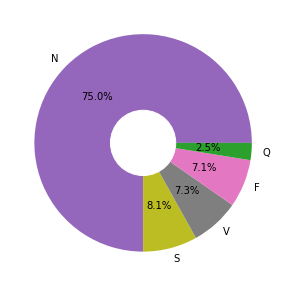

In [ ]:
df = pd.DataFrame(X) #Array to df
per_class = df[df.shape[1]-1].value_counts() #class distribution
print(per_class)
#visualizing class distribution
plt.figure(figsize=(5,5))
my_circle=plt.Circle( (0,0), 0.3, color='white')
plt.pie(per_class, labels=['N', 'S', 'V', 'F', 'Q'], colors=['tab:purple','tab:olive','tab:grey','tab:pink','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

#Train-Test split

In [ ]:
train,test=train_test_split(df,test_size=0.20) #train test split from the main dataframe
print("train : ", np.shape(train)) #train data shape
print("test  : ", np.shape(test)) #test data shape

train :  (80009, 361)
test  :  (20003, 361)


#Sampling Train Data

In [ ]:
#down sampling class 0
df_0=(train[train[train.shape[1]-1]==0]).sample(7000,random_state=42)

#up sampling class 1
df_1=train[train[train.shape[1]-1]==1]
df_1_upsample=resample(df_1,replace=True,n_samples=7000,random_state=23)

#up sampling class 2
df_2=train[train[train.shape[1]-1]==2]
df_2_upsample=resample(df_2,replace=True,n_samples=7000,random_state=23)

#up sampling class 3
df_3=train[train[train.shape[1]-1]==3]
df_3_upsample=resample(df_3,replace=True,n_samples=7000,random_state=23)

#up sampling class 4
df_4=train[train[train.shape[1]-1]==4]
df_4_upsample=resample(df_4,replace=True,n_samples=7000,random_state=23)


In [ ]:
train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])
#combining the sampled classes 

3.0    7000
4.0    7000
2.0    7000
1.0    7000
0.0    7000
Name: 360, dtype: int64


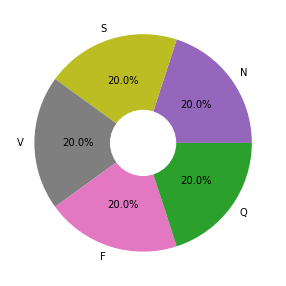

In [ ]:
per_class = train_df[train_df.shape[1]-1].value_counts()
print(per_class)
#visualizing the sampled training data
plt.figure(figsize=(5,5))
my_circle=plt.Circle( (0,0), 0.3, color='white')
plt.pie(per_class, labels=['N', 'S', 'V', 'F', 'Q'], colors=['tab:purple','tab:olive','tab:grey','tab:pink','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
#plt.title("Sampling in train data")
plt.show()

In [ ]:
train_df.shape #sampled training data shape

(35000, 361)

In [ ]:
per_class = train_df[train_df.shape[1]-1].value_counts()
per_class #checking the sampled train data class distribution

3.0    7000
4.0    7000
2.0    7000
1.0    7000
0.0    7000
Name: 360, dtype: int64

#Independent and Dependent variables in Test Data 

In [ ]:
#test data #hided from the model till evaluation
test_x= test.iloc[:,:test.shape[1]-1].values
test_x=test_x.reshape(len(test_x), test_x.shape[1],1) #reshaping to fit deep leanring models
test_y= test[test.shape[1]-1] 
test_y=to_categorical(test_y) #one hot encoding

In [ ]:
print("test_x : ", np.shape(test_x)) #independent variables of test data
print("test_y  : ", np.shape(test_y)) #dependent variables of test data

test_x :  (20003, 360, 1)
test_y  :  (20003, 5)


0.0    14973
1.0     1632
2.0     1462
4.0     1432
3.0      504
Name: 360, dtype: int64


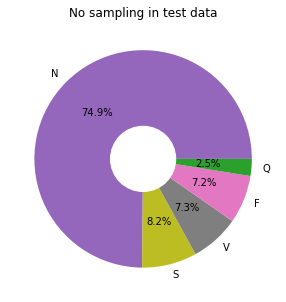

In [ ]:
per_class = test[test.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(5,5))
#visualize test data class distribution
my_circle=plt.Circle( (0,0), 0.3, color='white')
plt.pie(per_class, labels=['N', 'S', 'V', 'F', 'Q'], colors=['tab:purple','tab:olive','tab:grey','tab:pink','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title("No sampling in test data")
plt.show()

#Independent and dependent varibale in Training Data

In [ ]:
target_train=train_df[train_df.shape[1]-1] #label train
#target_val=val[val.shape[1]-1] #labes test
train_y=to_categorical(target_train)
#val_y=to_categorical(target_val)
print(np.shape(train_y))

(35000, 5)


In [ ]:
train_x = train_df.iloc[:,:train_df.shape[1]-1].values
#val_x = val.iloc[:,:val.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
#val_x = val_x.reshape(len(val_x), val_x.shape[1],1)
print(np.shape(train_x))

(35000, 360, 1)


In [ ]:
print("train_x : ", np.shape(train_x)) #independent variables in test data
print("train_y  : ", np.shape(train_y)) #dependent variable in test data
#print("val x : ", np.shape(val_x))
#print("val y  : ", np.shape(val_y))

train_x :  (35000, 360, 1)
train_y  :  (35000, 5)


#CNN Model

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold,KFold
import sklearn.metrics as metrics

In [ ]:
def cnn_model(): 
  model = Sequential()
  #convolution layer 1
  model.add(Conv1D(filters=16, kernel_size=13, padding='same', activation='relu',input_shape=(360, 1)))
  model.add(AvgPool1D(pool_size=3, strides=2))
  #convoulution layer 2
  model.add(Conv1D(filters=32, kernel_size=15, padding='same', activation='relu'))
  model.add(AvgPool1D(pool_size=3, strides=2))
  #convolution layer 3
  model.add(Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))
  model.add(AvgPool1D(pool_size=3, strides=2))
  #convolution layer 4
  model.add(Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))
  model.add(AvgPool1D(pool_size=3, strides=2))
  #flattening layer 
  model.add(Flatten())
  #Droupout threshold 0.5
  model.add(Dropout(0.5))
  #outer dense layer with 5 neurons represent 5 classes
  model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
  model.add(Softmax()) #probability of the classes
    
  model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
  model.summary()

  return model

cnn=cnn_model()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 360, 16)           224       
                                                                 
 average_pooling1d (AverageP  (None, 179, 16)          0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 179, 32)           7712      
                                                                 
 average_pooling1d_1 (Averag  (None, 89, 32)           0         
 ePooling1D)                                                     
                                                                 
 conv1d_2 (Conv1D)           (None, 89, 64)            34880     
                                                                 
 average_pooling1d_2 (Averag  (None, 44, 64)           0

##CNN model plot

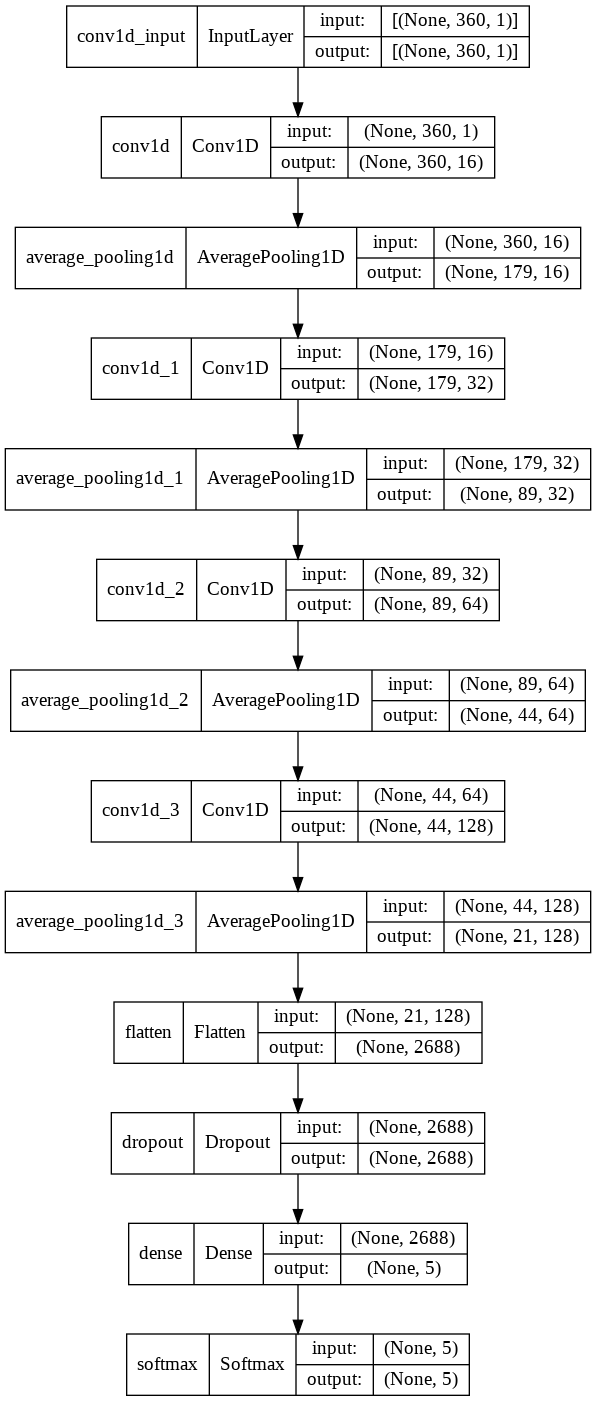

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(cnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

##KFold cross validation

In [ ]:
# Cross-Validate
kf = KFold(5, shuffle=True, random_state=42)
oos_y = []
oos_pred = []

acc_per_fold = []
loss_per_fold = []
rmse_per_fold=[]
fold = 0
for train, test in kf.split(train_x,train_y):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train=train_x[train]
    y_train=train_y[train]
    x_test=train_x[test]
    y_test=train_y[test]
    
    history=cnn.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=0,epochs=10)
    
    #cnn.append(fit_and_evaluate(x_train,x_test,y_train,y_test))
    print("======="*12, end="\n\n\n")
    pred = cnn.predict(x_test)
    
    oos_y.append(y_test)
    oos_pred.append(pred)  
    


    # Measure this fold's RMSE
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    rmse_per_fold.append(score)
    print(f"Fold score (RMSE): {score}")

    # Generate generalization metrics
    scores = cnn.evaluate(x_test,pred, verbose=0)
    print(f'Score for fold {fold}: {cnn.metrics_names[0]} of {scores[0]}; {cnn.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    
 
#Excetion time 1hr 5min


Fold #1


Fold score (RMSE): 0.04428451135754585
Score for fold 1: loss of 0.017903536558151245; accuracy of 100.0%
Fold #2


Fold score (RMSE): 0.03447260707616806
Score for fold 2: loss of 0.013071606867015362; accuracy of 100.0%
Fold #3


Fold score (RMSE): 0.03079649806022644
Score for fold 3: loss of 0.010622743517160416; accuracy of 100.0%
Fold #4


Fold score (RMSE): 0.019867466762661934
Score for fold 4: loss of 0.010924769565463066; accuracy of 100.0%
Fold #5


Fold score (RMSE): 0.028467869386076927
Score for fold 5: loss of 0.009683978743851185; accuracy of 100.0%


In [ ]:
average_acc=sum(acc_per_fold)/5 #to find average accuracy across 5 folds 
average_loss=sum(loss_per_fold)/5 #to find average loss across 5 folds
average_rmse=sum(rmse_per_fold)/5 # to find average rmse across 5 folds


##Training data Evaluation summary

In [ ]:
average_acc

100.0

In [ ]:
average_loss

0.012441327050328254

In [ ]:
average_rmse

0.03157779052853584

##CNN Test Data Evaluation

###Test Loss and Accuracy

In [ ]:
score = cnn.evaluate(test_x, test_y) #evaluating the models with the test data

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

626/626 [==============================] - 13s 21ms/step - loss: 0.0546 - accuracy: 0.9916
Test Loss: 0.054610349237918854
Test accuracy: 0.991601288318634


In [ ]:
y_pred = cnn.predict(test_x, batch_size=1000) #predictions from the cnn model 

###Test Data classification report

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 

print(classification_report(test_y.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     14921
           1       0.99      1.00      1.00      1567
           2       0.98      1.00      0.99      1517
           3       0.89      0.98      0.93       516
           4       0.97      1.00      0.98      1482

    accuracy                           0.99     20003
   macro avg       0.97      0.99      0.98     20003
weighted avg       0.99      0.99      0.99     20003



###Test Data Confusion Matrix

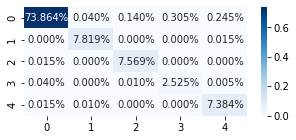

In [ ]:
import seaborn as sns
plt.figure(figsize=(5,2)) 
y_true=[]
for element in test_y:
    y_true.append(np.argmax(element))
prediction_proba=cnn.predict(test_x)
prediction=np.argmax(prediction_proba,axis=1)
model_cf_matrix = confusion_matrix(y_true, prediction) 
sns.heatmap(model_cf_matrix/np.sum(model_cf_matrix), annot=True,fmt='.3%', cmap='Blues')

In [ ]:
# Measure this RMSE
score = np.sqrt(metrics.mean_squared_error(y_true,prediction))
print(f"RMSE Score: {score}")

RMSE Score: 0.2857232128071667


#LSTM Model

In [ ]:
def get_lstm():
    lstm_model = Sequential()
    #one layer of LSTM
    lstm_model.add(LSTM(64, input_shape=(360,1)))
    #Fully connected dense layer
    lstm_model.add(Dense(128, activation = 'relu'))
    #dropout threshold 0.3
    lstm_model.add(Dropout(0.3))
    #outer dense layer with 5 neurons
    lstm_model.add(Dense(5, activation = 'softmax'))
    
    lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    lstm_model.summary()
    return lstm_model

lstm=get_lstm()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 25,861
Trainable params: 25,861
Non-trainable params: 0
_________________________________________________________________


##LSTM model plot

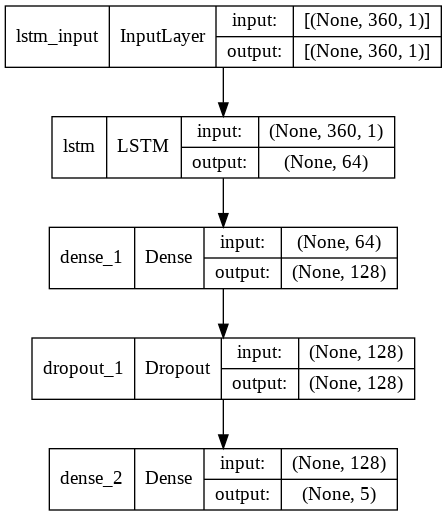

In [ ]:
plot_model(lstm, to_file='lstm_plot.png', show_shapes=True, show_layer_names=True)

##KFold Cross Validation

In [ ]:
# Cross-Validate
kf = KFold(5, shuffle=True, random_state=42) 
oos_y = []
oos_pred = []

lstm_acc_per_fold = []
lstm_loss_per_fold = []
lstm_rmse_per_fold=[]
fold = 0
for train, test in kf.split(train_x,train_y):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train=train_x[train]
    y_train=train_y[train]
    x_test=train_x[test]
    y_test=train_y[test]
    
    history=lstm.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=0,epochs=10)
    
    #cnn.append(fit_and_evaluate(x_train,x_test,y_train,y_test))
    print("======="*12, end="\n\n\n")
    pred = lstm.predict(x_test)
    
    oos_y.append(y_test)
    oos_pred.append(pred)  
    


    # RMSE with the validation test
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    lstm_rmse_per_fold.append(score)
    print(f"Fold score (RMSE): {score}")

    # LSTM evaluation scores with the validation test
    scores = lstm.evaluate(x_test,pred, verbose=0)
    print(f'Score for fold {fold}: {lstm.metrics_names[0]} of {scores[0]}; {lstm.metrics_names[1]} of {scores[1]*100}%')
    lstm_acc_per_fold.append(scores[1] * 100)
    lstm_loss_per_fold.append(scores[0])

    
 
#Execution time 1 hr 25 mins

Fold #1


Fold score (RMSE): 0.3921835422515869
Score for fold 1: loss of 1.5506789684295654; accuracy of 100.0%
Fold #2


Fold score (RMSE): 0.28612402081489563
Score for fold 2: loss of 0.8666079044342041; accuracy of 100.0%
Fold #3


Fold score (RMSE): 0.224198579788208
Score for fold 3: loss of 0.5140464901924133; accuracy of 100.0%
Fold #4


Fold score (RMSE): 0.2622559666633606
Score for fold 4: loss of 0.7752093076705933; accuracy of 100.0%
Fold #5


Fold score (RMSE): 0.2174302041530609
Score for fold 5: loss of 0.45254409313201904; accuracy of 100.0%


##Training data Evaluation Summary

In [ ]:
lstm_average_acc=sum(acc_per_fold)/5 #average of LSTM accuracy across 5 fold
lstm_average_loss=sum(loss_per_fold)/5 #average of LSTM loss across 5 fold
lstm_average_rmse=sum(rmse_per_fold)/5 #average of LSTM rmse across 5 fold

In [ ]:
lstm_average_acc

120.0

In [ ]:
lstm_average_loss

0.014929592460393906

In [ ]:
lstm_average_rmse

0.03789334863424301

##LSTM Test Data Evaluation

###Test Loss and Accuracy

In [ ]:
score = lstm.evaluate(test_x, test_y) #evaluation of LSTM on test data

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

626/626 [==============================] - 47s 75ms/step - loss: 0.4839 - accuracy: 0.8764
Test Loss: 0.48391321301460266
Test accuracy: 0.876368522644043


In [ ]:
y_pred = lstm.predict(test_x, batch_size=1000) #prediction by the LSTM model

###Test Data Classification Report

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 

print(classification_report(test_y.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93     14921
           1       0.79      0.93      0.86      1567
           2       0.57      0.92      0.70      1517
           3       0.39      0.68      0.50       516
           4       0.83      0.81      0.82      1482

    accuracy                           0.88     20003
   macro avg       0.71      0.85      0.76     20003
weighted avg       0.91      0.88      0.89     20003



###Test Data Confusion matrix

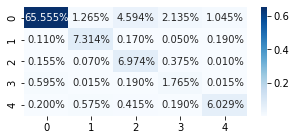

In [ ]:
y_true=[]
plt.figure(figsize=(5,2))

for element in test_y:
    y_true.append(np.argmax(element))
prediction_proba=lstm.predict(test_x)
prediction=np.argmax(prediction_proba,axis=1)
model_cf_matrix = confusion_matrix(y_true, prediction)
sns.heatmap(model_cf_matrix/np.sum(model_cf_matrix), annot=True,fmt='.3%', cmap='Blues')

In [ ]:

score = np.sqrt(metrics.mean_squared_error(y_true,prediction))
print(f"RMSE Score: {score}")

RMSE Score: 0.8643424881431426


#GRU Model

In [ ]:
def get_gru():
    gru_model = Sequential()
    #single layer GRU
    gru_model.add(GRU(64, input_shape=(360,1)))
    #fully connected outer layer
    gru_model.add(Dense(128, activation = 'relu'))
    #droput threshold 0.3
    gru_model.add(Dropout(0.3))
    #outer layer with 5 neurons
    gru_model.add(Dense(5, activation = 'softmax'))
    
    gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    gru_model.summary()
    return gru_model

gru=get_gru()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 21,829
Trainable params: 21,829
Non-trainable params: 0
_________________________________________________________________


##GRU Model Plot

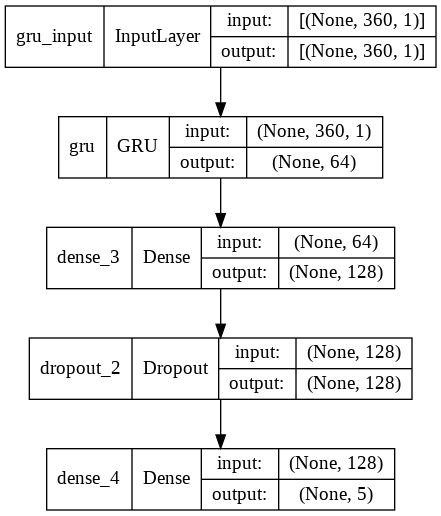

In [ ]:
plot_model(gru, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

##KFold cross Validation

In [ ]:
# Cross-Validate
kf = KFold(5, shuffle=True, random_state=42) 
oos_y = []
oos_pred = []

gru_acc_per_fold = []
gru_loss_per_fold = []
gru_rmse_per_fold=[]
fold = 0
for train, test in kf.split(train_x,train_y):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train=train_x[train]
    y_train=train_y[train]
    x_test=train_x[test]
    y_test=train_y[test]
    
    history=gru.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=0,epochs=10)
    
    #cnn.append(fit_and_evaluate(x_train,x_test,y_train,y_test))
    print("======="*12, end="\n\n\n")
    pred = gru.predict(x_test)
    
    oos_y.append(y_test)
    oos_pred.append(pred)  
    

#rmse scores for GRU
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    gru_rmse_per_fold.append(score)
    print(f"Fold score (RMSE): {score}")

    #GRU evaluation scores
    scores = gru.evaluate(x_test,pred, verbose=0)
    print(f'Score for fold {fold}: {gru.metrics_names[0]} of {scores[0]}; {gru.metrics_names[1]} of {scores[1]*100}%')
    gru_acc_per_fold.append(scores[1] * 100)
    gru_loss_per_fold.append(scores[0])

#execution time 1 hr 40 mins

Fold #1


Fold score (RMSE): 0.19267816841602325
Score for fold 1: loss of 0.33088359236717224; accuracy of 100.0%
Fold #2


Fold score (RMSE): 0.13655471801757812
Score for fold 2: loss of 0.18829283118247986; accuracy of 100.0%
Fold #3


Fold score (RMSE): 0.12072137743234634
Score for fold 3: loss of 0.12091086804866791; accuracy of 100.0%
Fold #4


Fold score (RMSE): 0.11064434051513672
Score for fold 4: loss of 0.10301440954208374; accuracy of 100.0%
Fold #5


Fold score (RMSE): 0.10682489722967148
Score for fold 5: loss of 0.10526067018508911; accuracy of 100.0%


##Training Data Evaluation summary

In [ ]:
gru_average_acc=sum(gru_acc_per_fold)/5 #GRU Average Accuracy
gru_average_loss=sum(gru_loss_per_fold)/5 #GRU average Loss
gru_average_rmse=sum(gru_rmse_per_fold)/5 #GRU average rmse

In [ ]:
gru_average_acc

100.0

In [ ]:
gru_average_loss

0.16967247426509857

In [ ]:
gru_average_rmse

0.13348470032215118

##GRU Test Data Evaluation

###Test Loss and Accuracy

In [ ]:
score = gru.evaluate(test_x, test_y) #Evaluation of GRU in test data

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

626/626 [==============================] - 17s 27ms/step - loss: 0.2486 - accuracy: 0.9266
Test Loss: 0.24857035279273987
Test accuracy: 0.9265609979629517


In [ ]:
y_pred = gru.predict(test_x, batch_size=1000) #GRU model prediction

###Test Data classification Report

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 

print(classification_report(test_y.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95     14973
           1       0.93      0.98      0.96      1632
           2       0.93      0.99      0.96      1462
           3       0.33      0.90      0.48       504
           4       0.86      0.97      0.91      1432

    accuracy                           0.93     20003
   macro avg       0.81      0.95      0.85     20003
weighted avg       0.96      0.93      0.94     20003



###Test Data confusion matrix

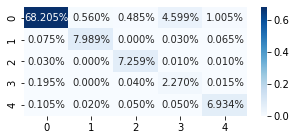

In [ ]:
import seaborn as sns
y_true=[]
plt.figure(figsize=(5,2))
for element in test_y:
    y_true.append(np.argmax(element))
prediction_proba=gru.predict(test_x)
prediction=np.argmax(prediction_proba,axis=1)
model_cf_matrix = confusion_matrix(y_true, prediction)
sns.heatmap(model_cf_matrix/np.sum(model_cf_matrix), annot=True,fmt='.3%', cmap='Blues')

In [ ]:
#RMSE of GRU
score = np.sqrt(metrics.mean_squared_error(y_true,prediction))
print(f"RMSE Score: {score}")

RMSE Score: 0.8052345866820809


#Acknowlegments


1. Wu M, Lu Y, Yang W and Wong SY (2021) A Study on Arrhythmia via ECG Signal Classification Using the Convolutional Neural Network. Front. Comput. Neurosci. 14:564015. doi: 10.3389/fncom.2020.564015
2. https://www.kaggle.com/yomnahesham/cse616-final-project
3.   https://github.com/PiasTanmoy/Conference-IVPR-5-ECG-Arrhythmia-Classification-Paper-2021/blob/main/Code/ecg_arrhythmia_classification.ipynb
4. https://www.kaggle.com/coni57/model-from-arxiv-1805-00794
5. https://github.com/SadmanSakib93/Stratified-k-fold-cross-validation-Image-classification-keras/blob/master/stratified_K_fold_CV.ipynb

